<a href="https://colab.research.google.com/drive/1r4RzLylgG4pcARVYwHjHkJ9lWvWlZk8z">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **Cloud detection - U-Net + mobilenetV2**

**paper:** CloudSEN12 - a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2s

**author:** Cesar Aybar

**NOTE: You need to upload cloudSEN12 to GCS to run this notebook successfully.**

---



### **1. Install packages**

In [9]:
# !apt-get install neofetch
!neofetch

            .-/+oossssoo+/-. 
        `:+ssssssssssssssssss+:` 
      -+ssssssssssssssssssyyssss+- 
    .ossssssssssssssssssdMMMNysssso. 
   /ssssssssssshdmmNNmmyNMMMMhssssss/ 
  +ssssssssshmydMMMMMMMNddddyssssssss+ 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/ 
  +sssssssssdmydMMMMMMMMddddyssssssss+ 
   /ssssssssssshdmNNNNmyNMMMMhssssss/ 
    .ossssssssssssssssssdMMMNysssso. 
      -+sssssssssssssssssyyyssss+- 
        `:+ssssssssssssssssss+:` 
            .-/+oossssoo+/-. 
root@efcced41d43e 
----------------- 
OS: Ubuntu 18.04.5 LTS x86_64 
Host: Google Compute Engine 
Kernel: 5.4.144+ 
Uptime: 7 mins 
Packages: 1396 
Shell: bash 4.4.20 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (16) @ 2.299GHz 
Memo

In [ ]:
!pip install albumentations --upgrade
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python
!pip install --upgrade opencv-python-headless
!pip install rasterio --upgrade
!pip install segmentation_models_pytorch --upgrade
!pip install pytorch-lightning
!pip install wandb
!pip install torchmetrics --upgrade

### **2. From GCS to the local computer**

![image](https://user-images.githubusercontent.com/16768318/179366014-077d1204-a67f-4efe-80d5-ef66f1596b0e.png)

In [43]:
!gsutil -m cp -r gs://dtacs/cloudSEN12 /content/

Copying gs://dtacs/cloudSEN12/valips.csv...
/ [1/1 files][ 39.5 KiB/ 39.5 KiB] 100% Done                                    
Operation completed over 1 objects/39.5 KiB.                                     


### **3. Load cloudSEN12**

In [1]:
import pandas as pd

# load the dataset
dataset_metadata = pd.read_csv("/content/cloudSEN12/cloudsen12_metadata.csv")
dataset_metadata_high = dataset_metadata[dataset_metadata["label_type"] == "high"]

# train/val/test split
train_val_db = dataset_metadata_high[dataset_metadata_high["test"] == 0]
train_val_db.reset_index(drop=True, inplace=True)

# train dataset
train_db = train_val_db.sample(frac=0.9, random_state=42)
train_db.reset_index(drop=True, inplace=True)


# val dataset
val_db = train_val_db.drop(train_db.index)
val_db.reset_index(drop=True, inplace=True)

# test dataset
test_db = dataset_metadata_high[dataset_metadata_high["test"] == 1]
test_db.reset_index(drop=True, inplace=True)

DATASET = [train_db, val_db, test_db]

### **4. Define augmentation**

In [2]:
import albumentations as A
import albumentations.pytorch

# Non destructive transformations - Dehidral group D4
nodestructive_pipe = A.OneOf([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5)
], p=1)

weak_augmentation = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, p=1, always_apply=True),
    nodestructive_pipe,
    albumentations.pytorch.transforms.ToTensorV2()
])

no_augmentation = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, p=1, always_apply=True),    
    albumentations.pytorch.transforms.ToTensorV2()
])

AUGMENTATION=weak_augmentation

### **5. Define the data DataLoader**

In [3]:
import torch
import numpy as np
import rasterio as rio
import warnings

# Create a DataLoader object.
class SEGDATALOADER(torch.utils.data.DataLoader):
    def __init__(self, dataset, augmentation=False):
        self.dataset = dataset
        self.augmentation = augmentation
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index: int):
        # Select the S2 and ROI id
        roi_id = self.dataset.loc[index, "roi_id"]
        s2_id = self.dataset.loc[index, "s2_id_gee"]

        # Load the numpy file
        s2l1c = f"/content/cloudSEN12/high/%s/%s/S2L1C.tif" % (roi_id, s2_id)
        with rio.open(s2l1c) as src:
            X = src.read()/10000 # B4, B3, B2
            X = np.moveaxis(X, 0, -1)
            #X = np.moveaxis(X, -1, 0)

        # Load target image.
        target = f"/content/cloudSEN12/high/%s/%s/labels/manual_hq.tif" % (roi_id, s2_id)
        with rio.open(target) as src:
            y = src.read(1)
        
        # Augmentation pipeline
        if self.augmentation:
            X, y = self.augmentation(image=X, mask=y).values()
            #X = np.moveaxis(X, -1, 0)
            
        # Check semantic_segmentation_pytorch model input shape requirements.                                
        if X.shape[0] > X.shape[2]:
            warnings.warn(
                "segmentation_models.pytorch expects channels first (B, C, H, W)"
            )
        return X, y, "%s__%s" % (roi_id, s2_id)

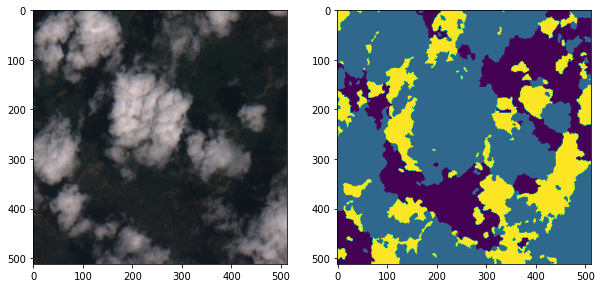

In [4]:
# Simple check
import matplotlib.pyplot as plt

# check dataloader
dataloader = SEGDATALOADER(dataset=DATASET[0], augmentation=weak_augmentation)
X, y, name = dataloader[100]

# create matplolib subfigure 2x1
fix, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X.moveaxis(0, 2)[:,:,[3,2,1]])
ax[1].imshow(y)
plt.show()

### **6. Define a model**

In [5]:
import segmentation_models_pytorch as smp 
SEGMODEL = smp.Unet(
        encoder_name="mobilenet_v2",
        encoder_weights=None,
        classes=4,
        in_channels=13        
)

### **7. Define a loss**

In [6]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        # flatten label and prediction tensors
        #input = input.view(-1)
        target = target.type(torch.long)
        BCE = torch.nn.functional.cross_entropy(input, target)
        return BCE
        
CRITERION = CrossEntropyLoss()

### **8. Define metrics**

In [7]:
import torch
from torchmetrics import Metric
from sklearn.metrics import fbeta_score, recall_score, precision_score

class BF2score(Metric):

    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = False

    def __init__(self, thershold: float = 0.90):
        super().__init__()
        self.add_state("container", default=torch.tensor(0), dist_reduce_fx="sum")        
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.thershold = thershold

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        score_container = list()
        for index in range(preds.shape[0]):
            score_container.append(fbeta_score(target[index].flatten().detach().cpu(), preds[index].flatten().detach().cpu(), average='macro', beta=2, zero_division=1))
        score_container = torch.Tensor(score_container)
        gt_thershold = score_container.gt(self.thershold)        
        self.container += torch.sum(gt_thershold)
        self.total += preds.shape[0]

    def compute(self):
        return self.container/self.total*100

class BPAscore(Metric):

    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = False

    def __init__(self, thershold: float = 0.90):
        super().__init__()
        self.add_state("container", default=torch.tensor(0), dist_reduce_fx="sum")        
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.thershold = thershold

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        score_container = list()
        for index in range(preds.shape[0]):
            score_container.append(recall_score(target[index].flatten().detach().cpu(), preds[index].flatten().detach().cpu(), average='macro', zero_division=1))
        score_container = torch.Tensor(score_container)
        gt_thershold = score_container.gt(self.thershold)        
        self.container += torch.sum(gt_thershold)
        self.total += preds.shape[0]

    def compute(self):
        return self.container/self.total*100


class BUAscore(Metric):

    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = False

    def __init__(self, thershold: float = 0.90):
        super().__init__()
        self.add_state("container", default=torch.tensor(0), dist_reduce_fx="sum")        
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.thershold = thershold

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        score_container = list()
        for index in range(preds.shape[0]):
            score_container.append(precision_score(target[index].flatten().detach().cpu(), preds[index].flatten().detach().cpu(), average='macro', zero_division=1))
        score_container = torch.Tensor(score_container)
        gt_thershold = score_container.gt(self.thershold)        
        self.container += torch.sum(gt_thershold)
        self.total += preds.shape[0]

    def compute(self):
        return self.container/self.total*100

METRICS = {"f2_score": BF2score(), "pa_score": BPAscore(), "ua_score": BUAscore()}

### **9. Define the logger (OPTIONAL)**

In [153]:
import os
from pytorch_lightning.loggers import WandbLogger
import wandb

#wandb.init(settings=wandb.Settings(start_method='fork'))
os.environ["WANDB_API_KEY"] = "put_here_wandb_key"
LOGGER = WandbLogger(project="cloudseg")

### **10. Create a Pytorch-lighning model**

In [8]:
from typing import Optional
import pytorch_lightning as pl
import torch

class litSegModel(pl.LightningModule):
    """
    Lightning Class template to wrap segmentation models.
    Args:
      hparams (`DictConfig`) : A `DictConfig` that stores the configs for training .
    """

    def __init__(self):
        super().__init__()
        #self.save_hyperparameters()  # Save the hyperparameters.
        self.model = SEGMODEL
        self.dataloader = SEGDATALOADER
        self.criterion = CRITERION
        self.metrics = METRICS
        self.dataset = DATASET
        self.augmentation = AUGMENTATION


    def prepare_data(self) -> None:
        """
        Change the file utils/prepare_data.py to this function. It must return
        SegDataset and SegDataLoader.
        """
        pass

    def setup(self, stage: Optional[str] = None) -> None:
        # train/val/test split
        train, val, test = self.dataset        
        if stage in (None, "fit"):
            self.dbtrain = self.dataloader(train, AUGMENTATION)
            self.dbval = self.dataloader(val, no_augmentation)

        if stage in (None, "test"):
            self.dbtest = self.dataloader(test,no_augmentation)

    def train_dataloader(self):        
        return torch.utils.data.DataLoader(
            dataset=self.dbtrain,
            batch_size=32,
            num_workers=0,
            pin_memory=False,
            shuffle=True,
        )

    def val_dataloader(self):        
        return torch.utils.data.DataLoader(
            dataset=self.dbval,
            batch_size=32,
            num_workers=0,
            pin_memory=False,
            shuffle=False,
        )

    def test_dataloader(self):        
        return torch.utils.data.DataLoader(
            dataset=self.dbtest,
            batch_size=32,
            num_workers=0,
            pin_memory=False,
            shuffle=False,
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self.forward(X)
        # save_breakpoint([y_hat, y])
        loss = self.criterion(y_hat, y)
        self.log("loss_train", loss, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self.forward(X)
        # save_breakpoint([y_hat, y])
        loss = self.criterion(y_hat, y)
        self.log("loss_val", loss, prog_bar=True, logger=True, on_epoch=True)

        # Update metrics
        if self.metrics is not None:
            y_hat_class = y_hat.argmax(dim=1)
            y = y.type(torch.long)

            # Iterate for each metric
            for value in self.metrics.values():
                value.update(y_hat_class, y)

        return loss

    def validation_epoch_end(self, val_metrics_results):
        if self.metrics is not None:
            for key, value in self.metrics.items():
                metric_value = value.compute()
                logging_name = key.lower() + "_val"
                self.log(
                    name=logging_name,
                    value=metric_value,
                    prog_bar=False,
                    logger=True,
                    on_epoch=True,
                )
                value.reset()

    def test_step(self, batch, batch_idx):
        if self.metrics is not None:
            # Update metrics
            X, y, _ = batch
            y_hat = self.forward(X).squeeze()
            
            y_hat_class = y_hat.argmax(dim=1)
            y = y.type(torch.long)

            # Iterate for each metric
            for value in self.metrics.values():
                value.update(y_hat_class, y)

    def test_epoch_end(self, outputs):
        if self.metrics is not None:
            for key, value in self.metrics.items():
                metric_value = value.compute()
                logging_name = key.lower() + "_test"
                self.log(
                    name=logging_name,
                    value=metric_value,
                    prog_bar=True,
                    logger=True,
                    on_epoch=True,
                )
                value.reset()

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimier to use   for training
        
        Returns:
            torch.optim.Optimier: the optimizer for updating the model's parameters
        """
        self.opt = torch.optim.AdamW(self.parameters(), lr=0.001)
        
        # Set a scheduler
        self.sch = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=self.opt,
                mode="min",
                factor=0.1,
                patience=4,
                verbose=True
            ),
            "frequency": 1, # 
            "monitor": "loss_val" # quantity to be monitored
        }
        return [self.opt], [self.sch]

### **11. Simple sanity check**

In [16]:
# check the class
self = litSegModel()
print("Checking DataLoader ...", end="\r")
self.prepare_data()
self.setup()
X, y, _ = next(iter(self.test_dataloader()))
print("Checking DataLoader ... [OK]")

# Checking Model
print("Checking Model ...", end="\r")
self = self.cuda()
y_hat = self(X.cuda())
print("Checking Model ... [OK]")

# Checking Criterion
print("Checking Criterion ...", end="\r")    
loss = CRITERION(y_hat, y.cuda())
print("Checking Criterion ... [OK]")


# Checking Optimizer
print("Checking Optimizer ...", end="\r")
loss.backward()
print("Checking Optimizer ... [OK]")

Checking DataLoader ... [OK]
Checking Model ... [OK]
Checking Criterion ... [OK]
Checking Optimizer ... [OK]


### **12. Setup a Trainer**

In [20]:
from pytorch_lightning import Trainer
import pytorch_lightning

mymodel = litSegModel()
callbacks = [
    pytorch_lightning.callbacks.EarlyStopping(monitor="loss_val", patience=10, mode="min"),
    pytorch_lightning.callbacks.ModelCheckpoint(monitor="loss_val", dirpath="bestmodel/", filename="ramiel", save_top_k=1, mode="min")
]
trainer = Trainer(gpus=2, max_epochs=50, precision=16, strategy='dp', callbacks=callbacks, logger=LOGGER)

# start train
trainer.fit(mymodel)

# start test
trainer.test(mymodel)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/bestmodel exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Unet             | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
13.265    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
